In [ ]:
import os.path
!kaggle datasets download awsaf49/brats20-dataset-training-validation

Dataset URL: https://www.kaggle.com/datasets/awsaf49/brats20-dataset-training-validation
License(s): CC0-1.0
100%|██████████████████████████████████████▉| 4.15G/4.16G [00:06<00:00, 816MB/s]
100%|███████████████████████████████████████| 4.16G/4.16G [00:06<00:00, 738MB/s]


##### Unzip only a subset of the dataset (first 60 patients) to save space
if you want to unzip all the data, use:
```bash
!unzip brats20-dataset-training-validation.zip
```

In [2]:
!unzip brats20-dataset-training-validation.zip "BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_0[0-5][0-9]/*"

Archive:  brats20-dataset-training-validation.zip
  inflating: BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_flair.nii  
  inflating: BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_seg.nii  
  inflating: BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_t1.nii  
  inflating: BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_t1ce.nii  
  inflating: BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_t2.nii  
  inflating: BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_002/BraTS20_Training_002_flair.nii  
  inflating: BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_002/BraTS20_Training_002_seg.nii  
  inflating: BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_002/BraTS20_Training_002_t1.nii  
  in

#### Dataset Structure
The Brain Tumor Segmentation (BraTS) 2020 dataset is a collection of multimodal Magnetic Resonance Imaging (MRI) scans used for the segmentation of brain tumors.

It includes MRI scans from glioma patients, providing four different MRI modalities (means 4 channels of information - 4 different volumes of the same region) per patient:

1. Native (T1)
2. Post-contrast T1-weighted (T1ce - contrast enhanced)
3. T2-weighted (T2)
4. T2-FLAIR (T2 - Fluid Attenuated Inversion Recovery)

These scans come with expert-annotated segmentation masks that delineate the tumor into various sub-regions, such as the necrotic and non-enhancing tumor core, the peritumoral edema, and the enhancing tumor.

Annotations (labels):
1. Label 0: Not Tumor (NT) volume
2. Label 1: Necrotic and non-enhancing tumor core (NCR/NET)
3. Label 2: Peritumoral edema (ED)
4. Label 3: Missing (No pixels in all the volumes contain label 3)
5. Label 4: GD-enhancing tumor (ET)

As there are no pixels with the label 3, we will be replacing label 3 with label 4 so that there is continuity between the labels, so the final labels will be:
1. Label 0: Not Tumor (NT) volume
2. Label 1: Necrotic and non-enhancing tumor core (NCR/NET)
3. Label 2: Peritumoral edema (ED)
4. Label 3: GD-enhancing tumor (ET)

necrotic /nekˈrɑː.t̬ɪk/ - tế bào hoại tử \
peritumoral edema /ɪˈdiː.mə/ - vùng phù nề quanh khối u

##### Structure of each patient's folder:
Each patient's folder contains the following files:
- `BraTS20_Training_XXX_flair.nii`: FLAIR MRI scan
- `BraTS20_Training_XXX_seg.nii`: Segmentation mask with tumor labels
- `BraTS20_Training_XXX_t1.nii`: T1-weighted MRI scan
- `BraTS20_Training_XXX_t1ce.nii`: T1-weighted MRI scan with contrast enhancement
- `BraTS20_Training_XXX_t2.nii`: T2-weighted MRI scan

In [2]:
import os
import nibabel as nib

ROOT_PATH = "/Users/hinsun/Workspace/ComputerScience/UNetWithBraTS"
TRAIN_DATASET_PATH = ROOT_PATH + "/data/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/"

# if os.path.exists(TRAIN_DATASET_PATH):
#     print("Train dataset path exists.")
# else:
#     print("Train dataset path does not exist.")

test_image_flair = nib.load(TRAIN_DATASET_PATH + "BraTS20_Training_355/BraTS20_Training_355_flair.nii")
test_image = test_image_flair.get_fdata()  # type: ignore

# (240, 240, 155) / float64
print("Shape: ", test_image.shape)
print("Dtype: ", test_image.dtype)

print("Min: ", test_image.min())
print("Max: ", test_image.max())

Shape:  (240, 240, 155)
Dtype:  float64
Min:  0.0
Max:  1854.603271484375


In [ ]:

# Find min and max values in the array
data_folders = list(os.listdir(TRAIN_DATASET_PATH))
modalities = ["flair", "t1", "t1ce", "t2"]

min_overall = float("inf")
max_overall = float("-inf")

for sampling in modalities:
    min_value = float("inf")
    max_value = float("-inf")
    count = 0

    for folder in data_folders:
        file_path = os.path.join(TRAIN_DATASET_PATH, folder, f"{folder}_{sampling}.nii")
        if not os.path.exists(file_path):
            continue

        image = nib.load(file_path).get_fdata()  # type: ignore
        current_min = image.min()
        current_max = image.max()

        min_value = min(current_min, min_value)
        max_value = max(current_max, max_value)

        count = count + 1

    min_overall = min(min_value, min_overall)
    max_overall = max(max_value, max_overall)

    print("The number of folders processed for ", sampling, ": ", count)
    print("Overall Min value in FLAIR images: ", min_value)
    print("Overall Max value in FLAIR images: ", max_value)

print("Final Overall Min value: ", min_overall)  # -7.943429470062256
print("Final Overall Max value: ", max_overall)  # 32767.0

##### Rescaling / Normalization
To ensure that the MRI data is on a consistent scale, we will apply Min-Max Scaling to each modality. This technique rescales the pixel intensity values to a standard range, typically [0, 1]. This normalization step is crucial for improving the performance and convergence of machine learning models, as it mitigates the effects of varying intensity distributions across different scans and modalities.

In [8]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# How to use MinMaxScaler
# data = [[-1, 2], [-0.5, 6], [0, 10], [1, 18]]
# print(scaler.fit_transform(data))

# Scale the test_image_flair array and then reshape it back to its original dimensions.
# This ensures the data is normalized/standardized for model input without altering its spatial structure.

# Note: MinMaxScaler expects 2D array as input, so we have to reshape the 3D image data accordingly.
# 1. FLAIR shape: (240, 240, 155)
# 2: Reshape to 2D: (240 * 240, 155)
# 3: Apply scaling
# 4: Reshape back to 3D: (240, 240, 155)
test_image_flair = scaler.fit_transform(test_image.reshape(-1, test_image.shape[-1])).reshape(test_image.shape)

print("Min: ", test_image_flair.min())  # 0.0
print("Max: ", test_image_flair.max())  # 1.0

Min:  0.0
Max:  1.0


In [9]:
# rescaling t1
# FIXME: have a problem in sample 355

SAMPLE = "355"
SAMPLE_PATH = TRAIN_DATASET_PATH + f'BraTS20_Training_{SAMPLE}/'

modalities = ["flair", "t1", "t1ce", "t2", "seg"]
modalities_image = {}

for modality in modalities:
    # Load image with nibabel
    image = nib.load(SAMPLE_PATH + f'BraTS20_Training_{SAMPLE}_{modality}.nii').get_fdata()

    if modality != "seg":
        # Rescale image
        image = scaler.fit_transform(image.reshape(-1, image.shape[-1])).reshape(image.shape)
        modalities_image[modality] = image
    else:
        # Do not rescale segmentation mask
        modalities_image[modality] = image

modalities_image["seg"]

memmap([[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
    

Slice Number: 95


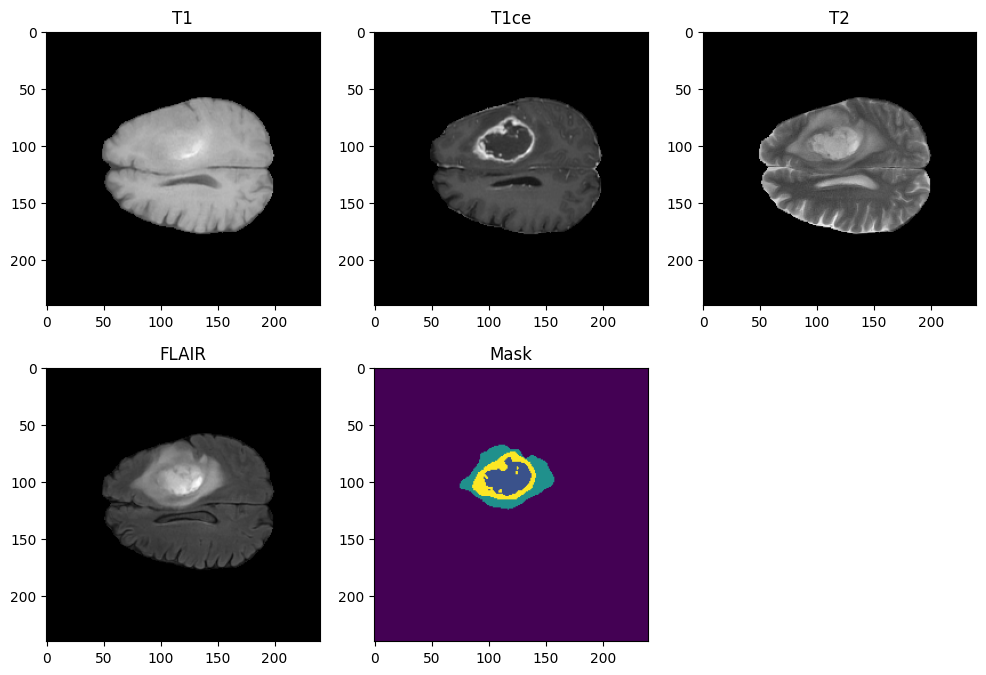

In [10]:
import matplotlib.pyplot as plt

# Slice number to visualize
slice = 95

print("Slice Number: " + str(slice))
plt.figure(figsize=(12, 8))

# T1
plt.subplot(2, 3, 1)
plt.imshow(modalities_image["t1"][:, :, slice], cmap="gray")
plt.title("T1")

# T1ce
plt.subplot(2, 3, 2)
plt.imshow(modalities_image["t1ce"][:, :, slice], cmap="gray")
plt.title('T1ce')

# T2
plt.subplot(2, 3, 3)
plt.imshow(modalities_image["t2"][:, :, slice], cmap="gray")
plt.title('T2')

# Flair
plt.subplot(2, 3, 4)
plt.imshow(modalities_image["flair"][:, :, slice], cmap="gray")
plt.title('FLAIR')

# Mask
plt.subplot(2, 3, 5)
plt.imshow(modalities_image["seg"][:, :, slice])
plt.title('Mask')
plt.show()

##### Detailed Description of Each Modality:
1. Native (T1): This modality reveals the structure and composition of various tissue type in the brain. It's instrumental in identifying tumors, cysts, and other abnormalities.
2. Post-contrast T1-weighted (T1ce, also known as T1Gd): Similar to T1, but enhanced with a contrast agent (Gadolinium), which improves the visibility of abnormalities.
3. T2-weighted (T2): This modality highlights the fluid content within brain tissue.
4. T2-FLAIR (T2 - Fluid Attenuated Inversion Recovery): This technique suppresses the fluid signals, making it easier to identify lesions that may not be visible on T1 or T2 images. It is particularly useful for detecting lesions in the brain's white matter, which are challenging to spot with other scans.

tumors /ˈtʃuː.mər/ - khối u \
tissue /ˈtɪs.juː/ - mô \
cyst /sɪst/ - u nang \
lesion /ˈliː.ʒən/ - tổn thương \

abnormality /ˌæb.nɔːrˈmæl.ə.t̬i/ - something that is not normal, usual, or expected in the body  \
contrast agent - a substance used in medical imaging to enhance the contrast of structures or fluids within the body structures, such as blood vessels, tissues, or organs, which helps doctors identify abnormalities.

##### Note
For medical experts, these four modalities collectively provide a comprehensive view, aiding in precise tumor analysis and confirmation. However, in our artificial intelligence approach, we aim to streamline the process by reducing computational and memory demands. Utilizing only two modalities can achieve this, making the segmentation task faster and more efficient.

To optimize our model, we will exclude the T1 modality since its enhanced counterpart, T1ce, provides better clarity. Similarly, we will omit the T2 modality because the fluids it highlights could negatively impact our predictions. Instead, the T2-FLAIR modality, which effectively highlights affected regions by suppressing fluid signals, will be more beneficial for our training.

##### Image Format - NIfTI (Neuroimaging Informatics Technology Initiative)
NIfTI is a widely used file format for storing medical imaging data, particularly in neuroimaging. It is designed to facilitate the sharing and analysis of brain imaging data across different software platforms.

As you know, the modalities and segmentations have 3 dimensions (240, 240, 155). Each dimension consists of a series of two-dimensional images, known as slices, which all contain the same number of pixels and are stacked together to create this 3D representation. For instance, in previous visualizations, we displayed the 95th slice of a certain dimension.

These 3 dimensions correspond to the three partial dimensions of the image: width, height and depth. In medical imaging, these dimensions are often referred to as the axial (transverse), coronal and sagittal planes.

Here is a brief explanation of each plane:
1. Axial (Transverse) Plane: This plane divides the body into upper and lower parts and is perpendicular to the long axis of the body. In brain imaging, an axial slice is a horizontal cut through the brain.
2. Coronal (Frontal) Plane: This plane divides the body into front (anterior) and back (posterior) parts. A coronal slice in brain imaging is a vertical cut from one side of the head to the other, dividing the brain into front and back sections.
3. Sagittal (Lateral) Plane: This plane divides the body into left and right parts. A sagittal slice in brain imaging is a vertical cut from front to back, dividing the brain into left and right sections.

Understanding these planes is crucial for accurately interpreting medical images and effectively utilizing them in segmentation tasks. Each plane provides a different perspective, helping to localize and identify anatomical structures and abnormalities.

Slice Number: 95


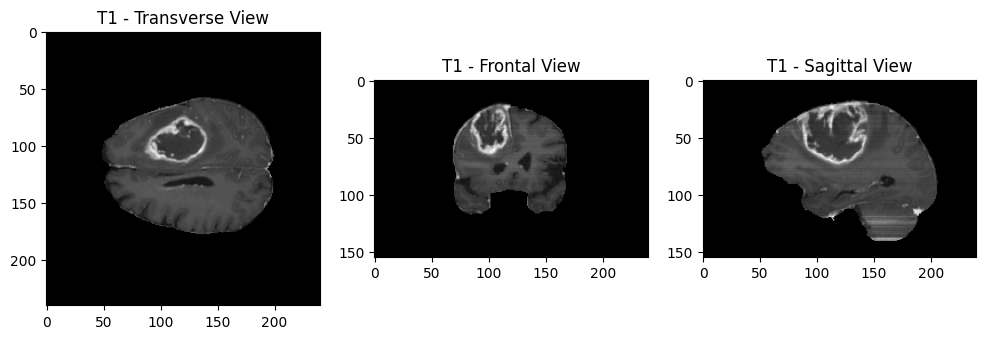

In [11]:
from skimage.transform import rotate

slice = 95
print("Slice Number: " + str(slice))

plt.figure(figsize=(12, 8))

# Apply a 90° rotation with an automatic resizing, otherwise the display is less obvious to analyze
# T1 - Transverse View
plt.subplot(1, 3, 1)
plt.imshow(modalities_image["t1ce"][:, :, slice], cmap="gray")
plt.title("T1 - Transverse View")

# T1 - Frontal View
plt.subplot(1, 3, 2)
plt.imshow(rotate(modalities_image["t1ce"][:, slice, :], 90, resize=True), cmap="gray")
plt.title("T1 - Frontal View")

# T1 - Sagittal View
plt.subplot(1, 3, 3)
plt.imshow(rotate(modalities_image["t1ce"][slice, :, :], 90, resize=True), cmap="gray")
plt.title("T1 - Sagittal View")
plt.show()

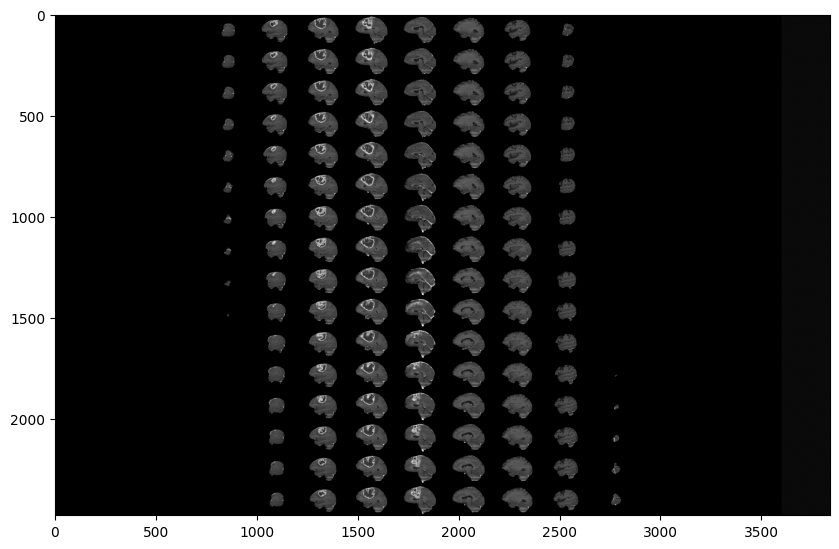

In [81]:
from skimage.util import montage

plt.figure(figsize=(10, 10))
plt.subplot(1, 1, 1)

# montage allows us to concatenate multiple images of the same size horizontally and vertically
image = rotate(montage(modalities_image["t1ce"][:, :, :]), 90, resize=True)
plt.imshow(image, cmap="gray")

As you can see, two black parts are present on each side of our montage. These black parts correspond to the first and last slices of the plane. This indicates that a large portion of the slices does not contain much information, which is expected as the slices progressively represent the brain from one end to the other.

This observation is consistent across all modalities, planes, and even the expert-segmented images. The experts were unable to segment the slices that lack significant information, as these slices mostly capture areas outside the brain or the outermost regions that do not contain relevant anatomical details.

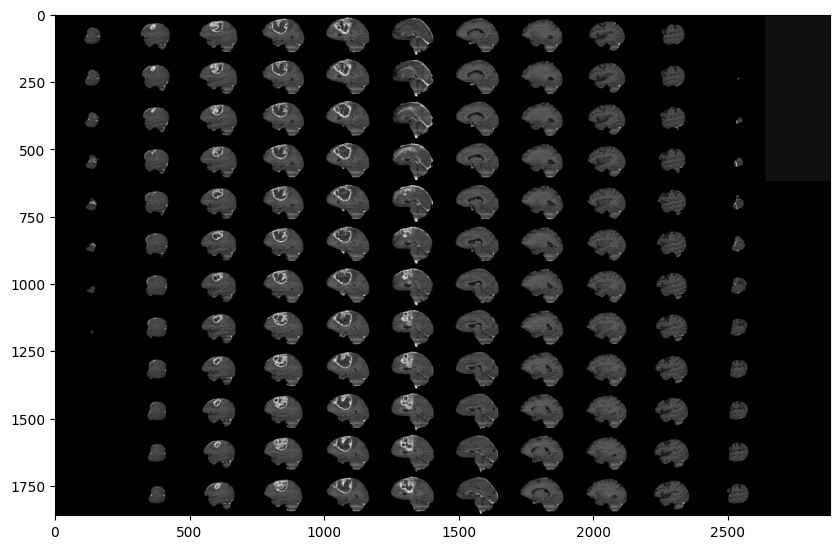

In [12]:
from skimage.util import montage

plt.figure(figsize=(10, 10))
plt.subplot(1, 1, 1)

# Skip 50:-50 slices since there is not much to see
image = rotate(montage(modalities_image["t1ce"][50:-50, :, :]), 90, resize=True)
plt.imshow(image, cmap="gray")

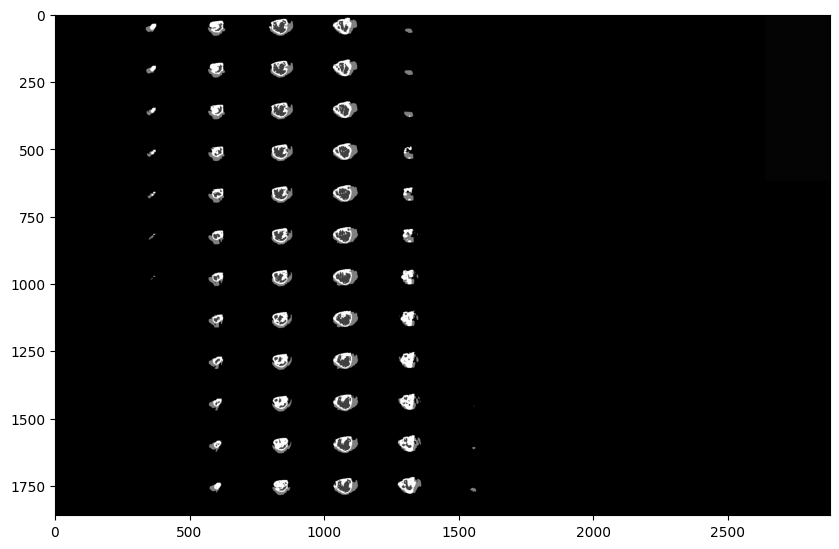

In [8]:
from skimage.util import montage

plt.figure(figsize=(10, 10))
plt.subplot(1, 1, 1)

# Skip 50:-50 slices since there is not much to see
image = rotate(montage(modalities_image["seg"][50:-50, :, :]), 90, resize=True)
plt.imshow(image, cmap="gray")

By focusing on a range of slices that contain meaningful content, we can better understand the anatomical structures and the regions where abnormalities, such as tumors, may be present. This approach helps in identifying the slices that are most relevant for analysis and segmentation.

This analysis applies to all other modalities and planes as well. The segmented images by experts also reflect this pattern, as they concentrate on the slices containing significant information. Slices that do not capture much of the brain's anatomy are often left unsegmented, as they provide little to no valuable data for diagnosis or analysis.

Now, let's focus on the segmentations provided by the experts. These segmentations provide critical information about the tumor:
1. Location: Identifies the exact location of the tumor in the brain.
2. Size and Shape: Measures the tumor's dimensions and form.
3. Type: Helps differentiate between various tumor types.
4. Heterogeneity: Reveals different components within the tumor (e.g., solid tissue, necrotic areas).
5. Surrounding Tissue Involvement: Shows how the tumor interacts with adjacent brain structures.
6. Cross-Modality Comparison: Provides a comprehensive view by comparing different imaging modalities.

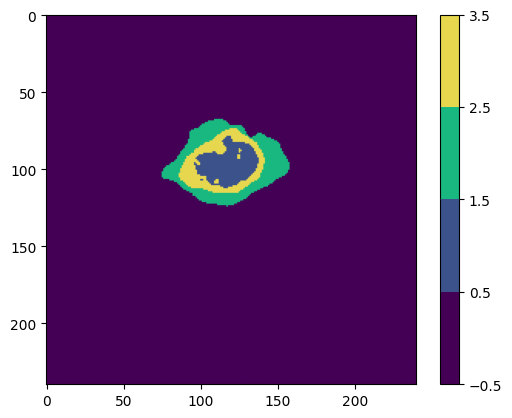

In [14]:
import matplotlib

# Plotting the segmentation
cmap = matplotlib.colors.ListedColormap(['#440054', '#3b528b', '#18b880', '#e6d74f'])
norm = matplotlib.colors.BoundaryNorm([-0.5, 0.5, 1.5, 2.5, 3.5], cmap.N)

image_seg = modalities_image["seg"]

# plotting the 95th slice
plt.imshow(image_seg[:, :, 95], cmap=cmap, norm=norm)
plt.colorbar()
plt.show()

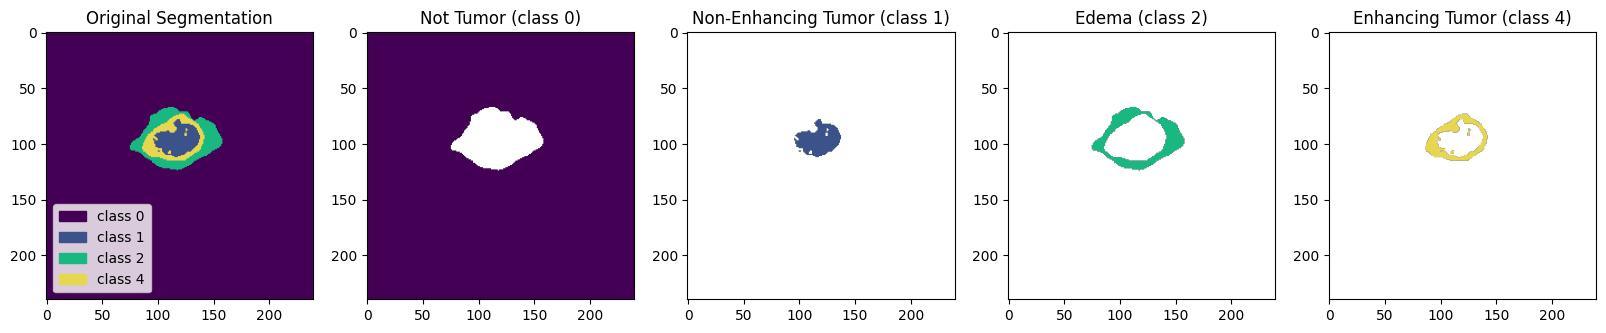

In [15]:
import numpy as np

# Isolation of class 0
seg_0 = image_seg.copy()
seg_0[seg_0 != 0] = np.nan

# Isolation of class 1
seg_1 = image_seg.copy()
seg_1[seg_1 != 1] = np.nan

# Isolation of class 2
seg_2 = image_seg.copy()
seg_2[seg_2 != 2] = np.nan

# Isolation of class 4
seg_4 = image_seg.copy()
seg_4[seg_4 != 4] = np.nan

# Define legend
class_names = ['class 0', 'class 1', 'class 2', 'class 4']

legend = [plt.Rectangle((0, 0), 1, 1, color=cmap(i), label=class_names[i]) for i in range(len(class_names))]

n = len(class_names)
if callable(cmap):
    colors = []

fig, ax = plt.subplots(1, 5, figsize=(20, 20))

ax[0].imshow(image_seg[:, :, slice], cmap=cmap, norm=norm)
ax[0].set_title('Original Segmentation')
ax[0].legend(handles=legend, loc='lower left')

ax[1].imshow(seg_0[:, :, slice], cmap=cmap, norm=norm)
ax[1].set_title('Not Tumor (class 0)')

ax[2].imshow(seg_1[:, :, slice], cmap=cmap, norm=norm)
ax[2].set_title('Non-Enhancing Tumor (class 1)')

ax[3].imshow(seg_2[:, :, slice], cmap=cmap, norm=norm)
ax[3].set_title('Edema (class 2)')

ax[4].imshow(seg_4[:, :, slice], cmap=cmap, norm=norm)
ax[4].set_title('Enhancing Tumor (class 4)')

plt.show()

##### Summary
1. Modalities: Each sample/patient has 4 different modalities (T1, T1CE, T2, and FLAIR), accompanied by a segmentation indicating tumor areas.
2. Selected Modalities: We will focus on T1CE and FLAIR as they provide complementary information about the brain's anatomy and tissue contrast.
3. 3D Images: Each image is 3D and can be analyzed through 3 different planes composed of 2D slices.
4. Informative Slices: Many slices contain little or no information. We will use slices in the (50:-50) interval. You can customize this range, but note that changing it may affect training time.
5. Segmentation Classes: Segmentation images contain 1 to 4 classes. Class 4 will be reassigned to 3 since class 3 is missing.
6. Background Class: Class 0 (background) is over-represented. Cropping might remove important information, so we will keep the images as they are.

In [16]:
from sklearn.model_selection import train_test_split


def pathListIntoIds(dirList):
    x = []
    for i in range(0, len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/') + 1:])

    return x


train_and_val_directories = [f.path for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]

train_and_test_ids = pathListIntoIds(train_and_val_directories)
train_test_ids, val_ids = train_test_split(train_and_test_ids, test_size=0.2)
train_ids, test_ids = train_test_split(train_test_ids, test_size=0.15)

# Print data distribution (Train: 68%, Test: 12%, Val: 20%)
print(f"Train length: {len(train_ids)}")  # 250
print(f"Validation length: {len(val_ids)}")  # 74
print(f"Test length: {len(test_ids)}")  # 45

Train length: 250
Validation length: 74
Test length: 45


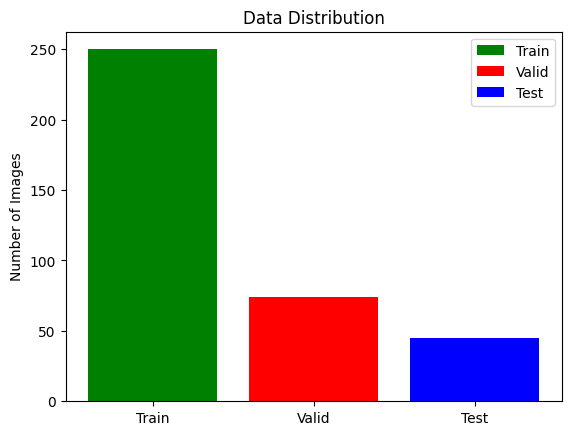

In [17]:
plt.bar(
    ["Train", "Valid", "Test"],
    [len(train_ids), len(val_ids), len(test_ids)],
    align='center',
    color=['green', 'red', 'blue'],
    label=["Train", "Valid", "Test"]
)

plt.legend()

plt.ylabel('Number of Images')
plt.title('Data Distribution')

plt.show()

##### Data Generator for Image Preprocessing

To train a neural network for image segmentation, we need both raw image data (X) and ground truth segmentations (y). This allows the network to learn tumor patterns and make accurate predictions from patient scans. However, directly loading all 3D images can overload system memory and cause shape mismatch errors. Therefore, we use a Data Generator for image preprocessing, which includes several steps:
1. Retrieve paths: Obtain the paths for the T1CE and FLAIR modalities (for complementary anatomical and tissue contrast information) and the ground truth segmentation.
2. Load data: Load the selected slices (60-135) from these modalities and the corresponding segmentation.
3. Create array: Form X arrays with the slices from T1CE and FLAIR, and y arrays with the segmentation slices.
4. Class reassignment: Assign a value of 3 to all instances of 4 in the mask array to correct the missing class issue.

Additional preprocessing steps include:
1. Axial plane: Use the axial plane for its square shape (240x240). This enables visualizing predictions across all planes without impact.
2. One-hot encoding: Apply One-Hot Encoding to the y array to convert classes (0 to 3) into a numerical format suitable for neural networks, avoiding any implied hierarchy between classes. Here is what it consists of, for one slice:
3. Resize images: Resize each slice from (240x240) to (128x128). This shape is chosen because it is a power of two, fitting well with pooling layers (MaxPooling2D) in CNNs, and balances computational efficiency and information preservation.

While resizing to (256x256) could retain more detail, it significantly increases training time and memory usage. We can choose to train with (256x256) images, but we’ll need to adjust your U-Net architecture accordingly.

Now that we have a clear understanding of our data and preprocessing steps, we can proceed to prepare our model for training.

In [18]:
# Define seg-areas
SEGMENT_CLASSES = {
    0: "Not Tumor (NT) volume",
    1: "NECROTIC/CORE",  # Necrotic and non-enhancing tumor core (NCR/NET)
    2: "EDEMA",  # Peritumoral edema (ED)
    3: "ENHANCING",  # GD-enhancing tumor (ET) - originally label 4 -> converted to 3
}

# Select Slices and Image Size
VOLUME_SLICES = 100
VOLUME_START_AT = 20  # first slice of volume that we will include
IMAGE_SIZE = 128

In [19]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import cv2


class BraTSDataset(Dataset):
    """
    BraTS Dataset for Brain Tumor Segmentation
    
    Returns:
        image: (2, img_size, img_size) - T1CE and FLAIR channels
        mask: (4, img_size, img_size) - One-hot encoded segmentation (classes 0, 1, 2, 3)
    """
    def __init__(self, root_dir, ids_list, transform=None):
        self.root_dir = root_dir
        self.ids_list = ids_list
        self.transform = transform
        self.scaler = MinMaxScaler()

    def __len__(self):
        return len(self.ids_list) * VOLUME_SLICES

    def __getitem__(self, idx):
        # Calculate which patient and which slice
        patient_idx = idx // VOLUME_SLICES
        slice_idx = idx % VOLUME_SLICES + VOLUME_START_AT
        
        patient_id = self.ids_list[patient_idx]
        patient_path = os.path.join(self.root_dir, patient_id)
        
        # Load T1CE, FLAIR, and segmentation
        t1ce = nib.load(f"{patient_path}/{patient_id}_t1ce.nii").get_fdata() # type: ignore
        flair = nib.load(f"{patient_path}/{patient_id}_flair.nii").get_fdata() # type: ignore
        seg = nib.load(f"{patient_path}/{patient_id}_seg.nii").get_fdata() # type: ignore
        
        # Get specific slice (axial plane)
        t1ce_slice = t1ce[:, :, slice_idx]
        flair_slice = flair[:, :, slice_idx]
        seg_slice = seg[:, :, slice_idx]
        
        # Normalize with Min-Max scaling
        t1ce_slice = self.scaler.fit_transform(t1ce_slice.reshape(-1, 1)).reshape(240, 240)
        flair_slice = self.scaler.fit_transform(flair_slice.reshape(-1, 1)).reshape(240, 240)
        
        # Resize to target size
        t1ce_slice = cv2.resize(t1ce_slice, (IMAGE_SIZE, IMAGE_SIZE))
        flair_slice = cv2.resize(flair_slice, (IMAGE_SIZE, IMAGE_SIZE))
        seg_slice = cv2.resize(seg_slice, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_NEAREST)
        
        # Replace label 4 with label 3 (to have continuous labels: 0, 1, 2, 3)
        seg_slice[seg_slice == 4] = 3
        
        # Stack T1CE and FLAIR as 2 channels
        image = np.stack([t1ce_slice, flair_slice], axis=0)  # (2, H, W)
        
        # One-hot encode the mask
        mask = self._one_hot_encode(seg_slice, num_classes=4)  # (4, H, W)
        
        # Convert to tensors
        image = torch.from_numpy(image).float()
        mask = torch.from_numpy(mask).float()
        
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        
        return image, mask
    
    def _one_hot_encode(self, mask, num_classes=4):
        one_hot = np.zeros((num_classes, mask.shape[0], mask.shape[1]), dtype=np.float32)
        for i in range(num_classes):
            one_hot[i][mask == i] = 1.0
        return one_hot


# Create datasets
train_dataset = BraTSDataset(TRAIN_DATASET_PATH, train_ids)
val_dataset = BraTSDataset(TRAIN_DATASET_PATH, val_ids)
test_dataset = BraTSDataset(TRAIN_DATASET_PATH, test_ids)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Val dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

# Test loading one sample
sample_image, sample_mask = train_dataset[0]
print(f"\nSample image shape: {sample_image.shape}")  # Should be (2, 128, 128)
print(f"Sample mask shape: {sample_mask.shape}")      # Should be (4, 128, 128)

Train dataset size: 25000
Val dataset size: 7400
Test dataset size: 4500

Sample image shape: torch.Size([2, 128, 128])
Sample mask shape: torch.Size([4, 128, 128])


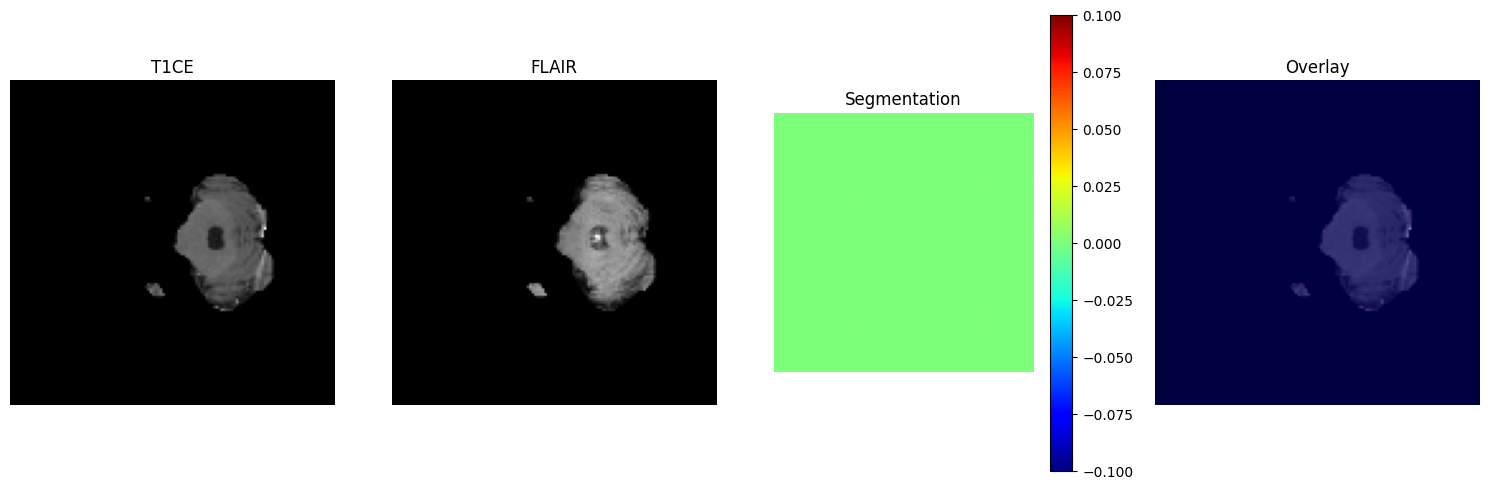

Class distribution in this sample:
  Class 0 (Not Tumor (NT) volume): 16384 pixels (100.00%)
  Class 1 (NECROTIC/CORE): 0 pixels (0.00%)
  Class 2 (EDEMA): 0 pixels (0.00%)
  Class 3 (ENHANCING): 0 pixels (0.00%)


In [21]:
# Visualize a sample from the dataset
sample_image, sample_mask = train_dataset[500]

# Convert to numpy for plotting
img_np = sample_image.numpy()
mask_np = sample_mask.numpy()

# Convert one-hot mask to class indices
mask_classes = np.argmax(mask_np, axis=0)

plt.figure(figsize=(15, 5))

# T1CE
plt.subplot(1, 4, 1)
plt.imshow(img_np[0], cmap="gray")
plt.title("T1CE")
plt.axis("off")

# FLAIR
plt.subplot(1, 4, 2)
plt.imshow(img_np[1], cmap="gray")
plt.title("FLAIR")
plt.axis("off")

# Segmentation
plt.subplot(1, 4, 3)
plt.imshow(mask_classes, cmap="jet")
plt.title("Segmentation")
plt.colorbar()
plt.axis("off")

# Overlay
plt.subplot(1, 4, 4)
plt.imshow(img_np[0], cmap="gray")
plt.imshow(mask_classes, cmap="jet", alpha=0.5)
plt.title("Overlay")
plt.axis("off")

plt.tight_layout()
plt.show()

print("Class distribution in this sample:")
for i in range(4):
    pixels = np.sum(mask_classes == i)
    percentage = pixels / (IMAGE_SIZE * IMAGE_SIZE) * 100
    print(f"  Class {i} ({list(SEGMENT_CLASSES.values())[i]}): {pixels} pixels ({percentage:.2f}%)")